In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image

Using TensorFlow backend.


In [2]:
# constants / config

# data directory
data_dir = os.getcwd() + '/data'

# 1 second pixel width
SEC = 128

# random number generator seed
SEED = 42

In [3]:
# load scalograms from directory
def load_scal(data_dir):
    images = []
    # append images to list
    for filename in os.listdir(data_dir):
        img = Image.open(os.path.join(data_dir, filename))
        images.append(img)
    
    # convert images to np array
    scal = [np.array(img) for img in images]
    
    return scal

scalograms = load_scal(data_dir)

In [4]:
# type cast to float32
# standardize to mean +- 3 std and clip
def standardize(scalograms):
    #scalograms = [(s.astype(np.float32) - 127.5)/127.5 for s in scalograms]
    scalograms = [s.astype(np.float32) for s in scalograms] # type cast to np.float32
    scalograms = [(s - np.mean(s)) / np.std(s) for s in scalograms] # standardize
#     scalograms = [np.clip(s, np.mean(s) - 3*np.std(s), np.mean(s) + 3*np.std(s)) for s in scalograms] # clip 
    
    for s in scalograms:
        print('min: %f, max: %f, mean: %f, std: %f' % (np.min(s), np.max(s), np.mean(s), np.std(s)))
        
#     norm = plt.Normalize(-1,1) # normalization for pyplot    
        
    return scalograms
        
std_scalograms = standardize(scalograms)

min: -36.417568, max: 0.148558, mean: -0.000072, std: 0.999994
min: -18.317778, max: 0.182846, mean: -0.000158, std: 0.999999


In [5]:
# delete first 10000 columns of sc0
std_scalograms[0] = std_scalograms[0][:, 10500:]

In [6]:
sc0_frames = [
    [22000, 22700], 
    [23000, 23700], 
    [23700, 24400], 
    [24400, 25100], 
    [24800, 25500], 
    [25500, 26200],
    [47400, 48100], 
    [48200, 48900], 
    [48900, 49600], 
    [49500, 50200], 
    [50000, 50700], 
    [50800, 51500],
    [71700, 72400], 
    [72500, 73200], 
    [73200, 73900], 
    [74900, 75600],
    [98800, 99500],
    [99800, 100500], 
    [100400, 101100], 
    [100900, 101600], 
    [101400, 102100], 
    [102200, 102900], 
    [125000, 125700], 
    [126000, 126700], 
    [126500, 127200], 
    [127000, 127700], 
    [127700, 128400], 
    [128200, 128900], 
]

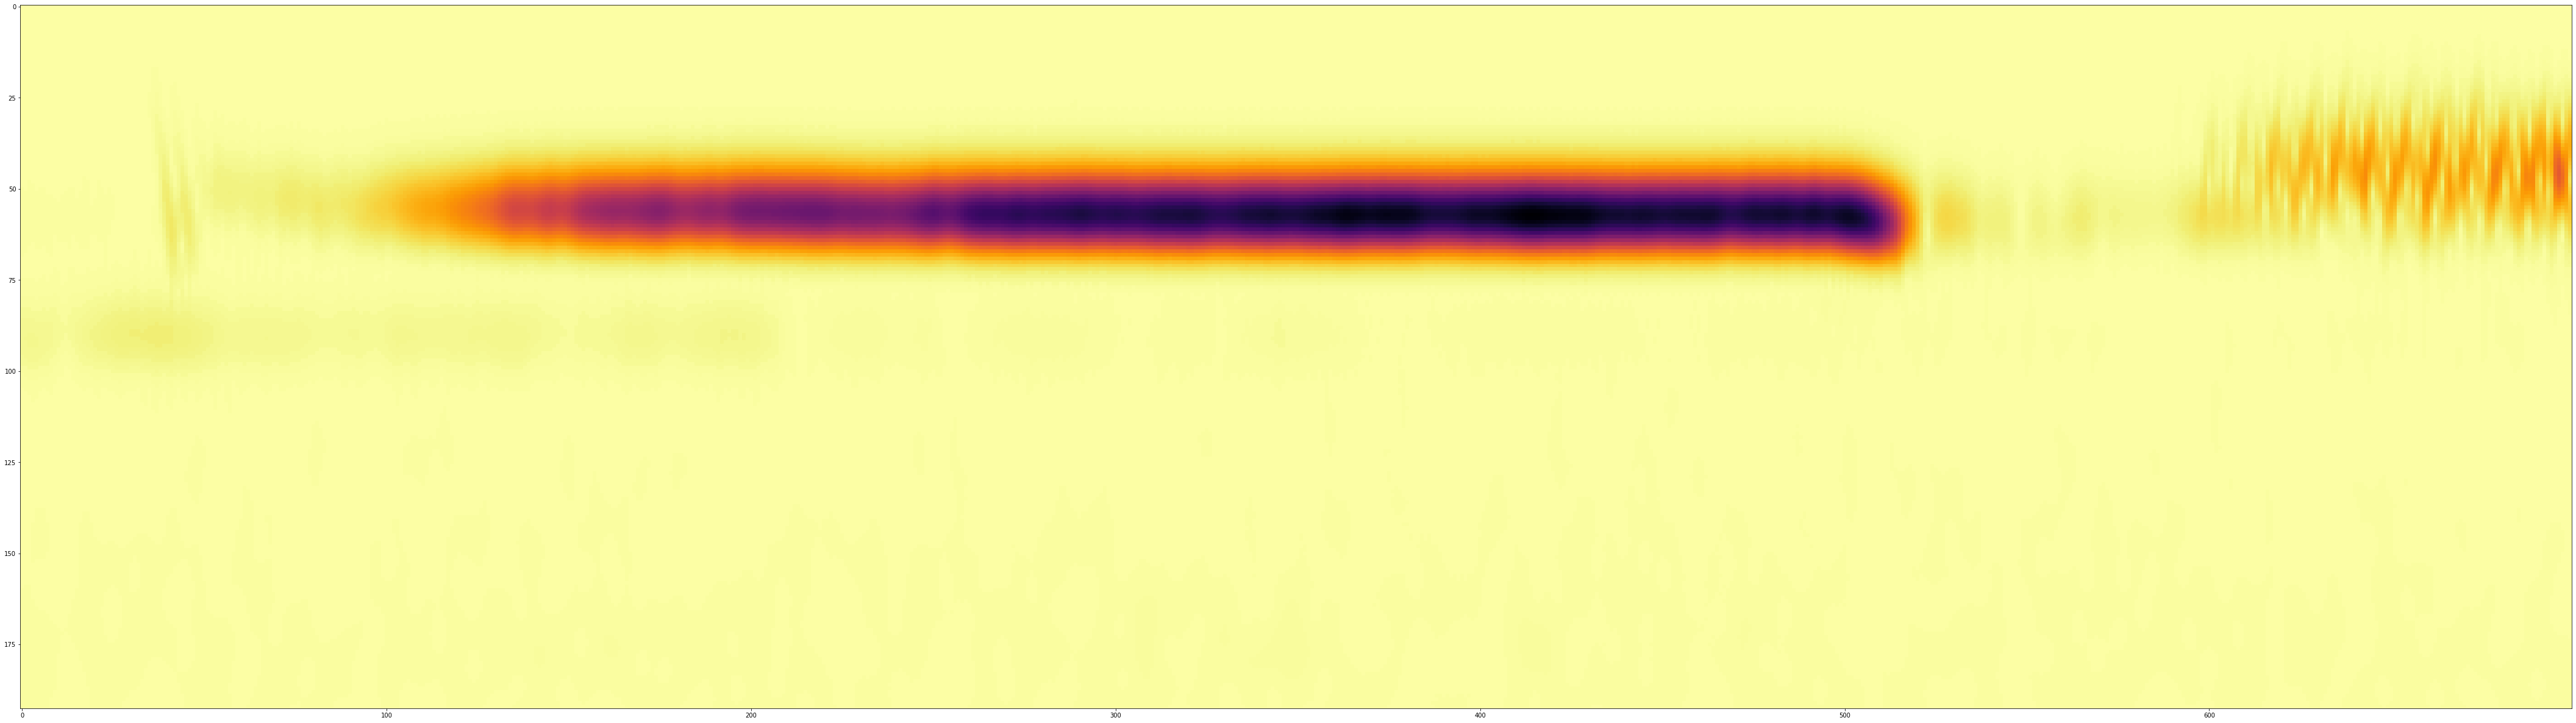

In [7]:
sc0 = std_scalograms[0]

plt.figure(figsize=(75,150))
plt.imshow(sc0[:, 100400:101100], cmap='inferno')
plt.show()

In [8]:
sc1_frames = [
    [10500,11200],
    [11600,12300],
    [12700,13400],
    [13900,14600],
    [15100,15800],
    [16400,17100],
    [17700,18400],
    [18900,19600],
    [20100,20800],
    [21200,21900],
    [22300,23000],
    [23500,24200],
    [24800,25500],
    [25900,26600],
    [27100,27800],
    [28100,28800],
    [33500,34200],
    [34500,35200],
    [35600,36300],
    [36700,37400],
    [38000,38700],
    [39200,39900],
    [40400,41100],
    [41600,42300],
    [42800,43500],
    [43900,44600],
    [45100,45800],
    [46200,46900],
    [48600,49300],
    [49700,50400],
    [50900,51600],
    [52100,52800],
    [60600,61300],
    [62500,63200],
    [63700,64400],
    [68600,69300] # this is enough for now.
]

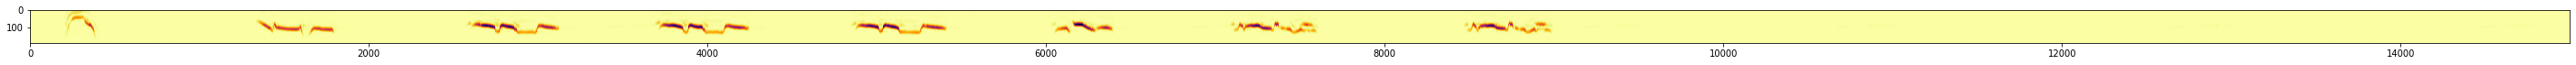

In [9]:
sc1 = std_scalograms[1]

plt.figure(figsize=(50,100))
plt.imshow(sc1[:, 70000:85000], cmap='inferno')
plt.show()

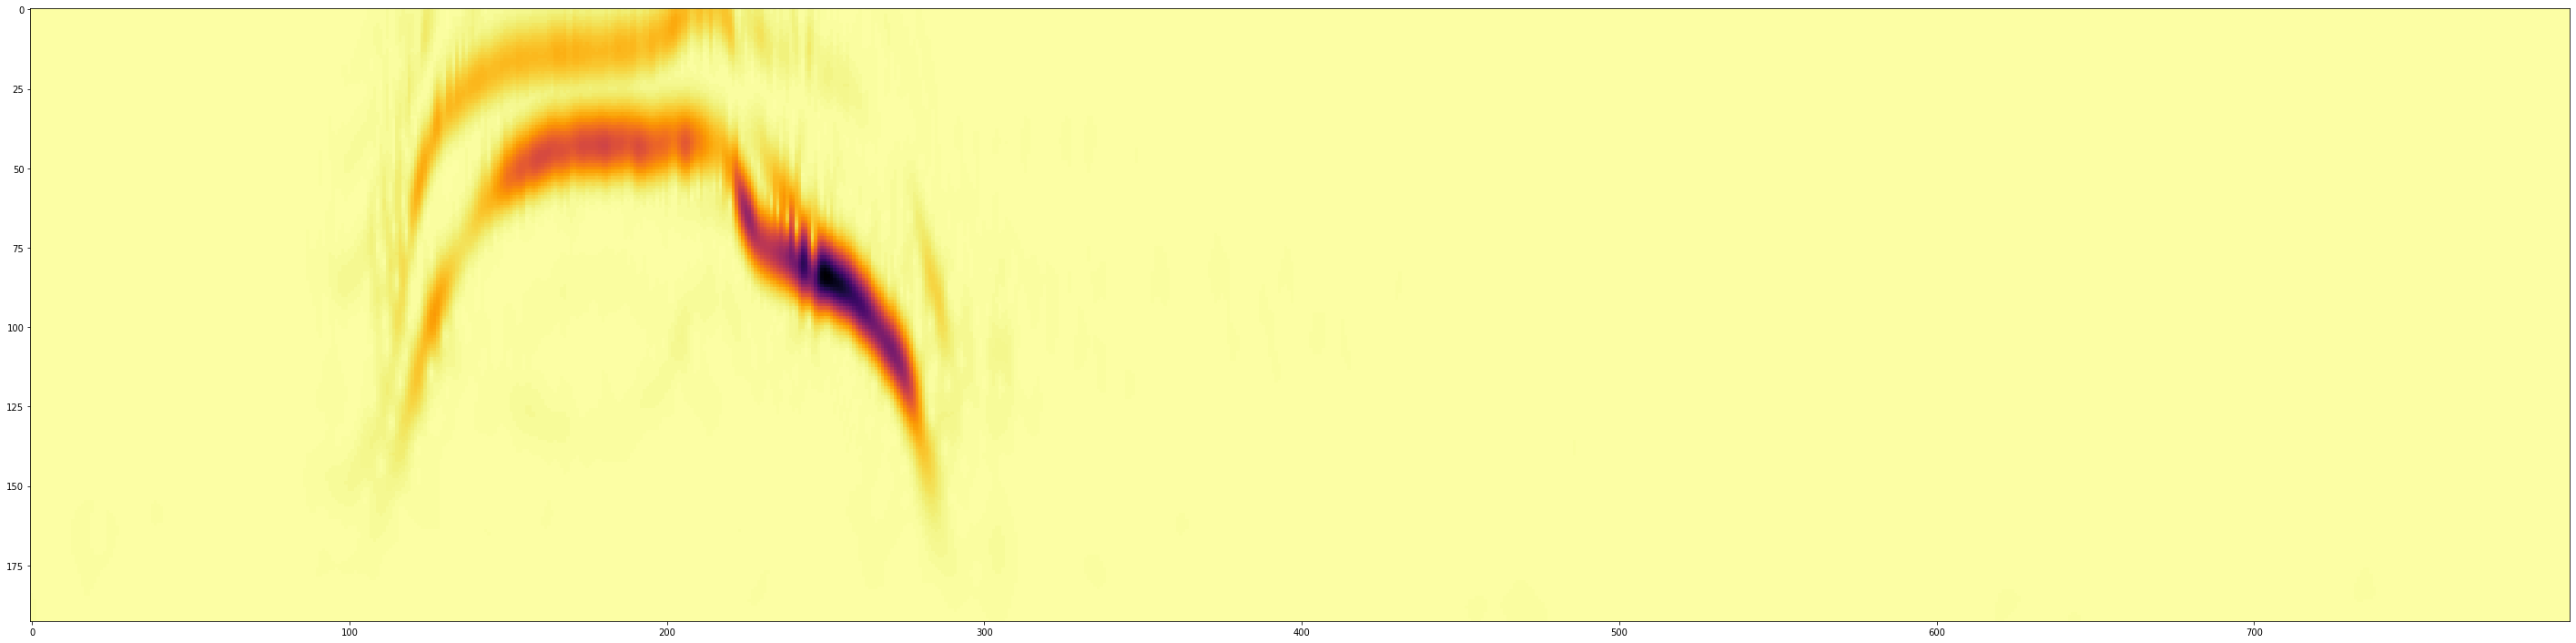

In [10]:
plt.figure(figsize=(50,100))
plt.imshow(sc1[:, 70100:70900], cmap='inferno')
plt.show()

In [11]:
frames = [
    sc0_frames,
    sc1_frames
]



In [12]:
def make_dataset(frames, scalograms):
    
    x = [] # data
    y = [] # label
    
    for i,(f,s) in enumerate(zip(frames, scalograms)):
        for [a,b] in f:
            frame = np.array(s[:, a:b])
#             print(frame.shape)
            x.append(frame)
            y.append(i)
            
    # convert to np array
    x = np.array(x)
    y = np.array(y)
    
    return x,y

X, y = make_dataset(frames, std_scalograms)

In [13]:
# shuffle dataset in unison
p = np.random.RandomState(seed=SEED).permutation(len(X))

X = X[p]
y = y[p]

In [14]:
x_train, x_test = np.split(X, [-4])
y_train, y_test = np.split(y, [-4])

In [15]:
x_train = x_train.reshape((-1, 193, 700, 1))
x_test = x_test.reshape((-1, 193, 700, 1))

In [16]:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [17]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False)

In [18]:
datagen.fit(x_train)

In [30]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu', input_shape=(193,700,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 189, 696, 32)      832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 94, 348, 32)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 94, 348, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 344, 32)       25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 172, 32)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 45, 172, 32)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 247680)            0         
__________

In [32]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [28]:
epochs = 5

In [33]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=10), steps_per_epoch=len(x_train)/10, epochs=epochs)

Epoch 1/5
6/6 [==============================] - 11s 2s/step - loss: 4.5446 - acc: 0.5500
Epoch 2/5
6/6 [==============================] - 8s 1s/step - loss: 2.1235 - acc: 0.8000
Epoch 3/5
6/6 [==============================] - 9s 1s/step - loss: 2.1681 - acc: 0.8500
Epoch 4/5
6/6 [==============================] - 9s 1s/step - loss: 1.9407 - acc: 0.8333
Epoch 5/5
6/6 [==============================] - 9s 1s/step - loss: 0.4790 - acc: 0.9500


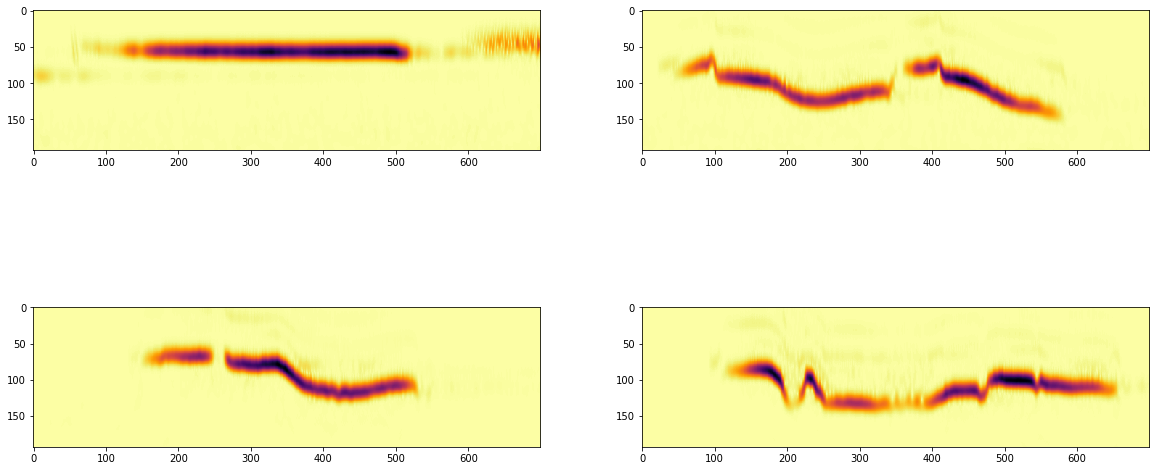

In [42]:
plt.figure(figsize=(20,10))
for i,s in enumerate(x_test):
    plt.subplot(2,2,i+1)
    plt.imshow(s.reshape(193, 700), cmap='inferno')
plt.show()

In [35]:
y_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [36]:
model.evaluate(x_test,y_test)

4/4 [==============================] - 1s 133ms/step


[1.1920928955078125e-07, 1.0]